In [1]:
# load required libraries & modules
%load_ext autoreload
%autoreload 2

import os
from tqdm.notebook import tqdm
import pprint
import time
import warnings
# warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import torch

from utils import *
from loaddata import *
# from visualization import *
from ourmodel import *

torch.set_grad_enabled(False)
torch.set_printoptions(sci_mode=False)

DATA_DIR = '../data'
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cpu')

BATCHSIZE = 100

# PATH_MNISTC = '../data/MNIST_C/'
# CORRUPTION_TYPES = ['identity', 
#          'shot_noise', 'impulse_noise','glass_blur','motion_blur',
#          'shear', 'scale',  'rotate',  'brightness',  'translate',
#          'stripe', 'fog','spatter','dotted_line', 'zigzag',
#          'canny_edges']

# CORRUPTION_INTEREST = ['glass_blur','motion_blur', 'impulse_noise','shot_noise',
#         'fog','dotted_line','spatter', 'zigzag']

ACC_TYPE = "entropy"

#################
# model load
################
def load_model(args):
    # load model
    model = RRCapsNet(args).to(args.device) 
    model.load_state_dict(torch.load(args.load_model_path, map_location=args.device))
    return model

def load_args(load_model_path, args_to_update, verbose=False):
    params_filename = os.path.dirname(load_model_path) + '/params.txt'
    assert os.path.isfile(params_filename), "No param flie exists"
    args = parse_params_wremove(params_filename, removelist = ['device']) 
    args = update_args(args, args_to_update)
    args.load_model_path = load_model_path
    if verbose:
        pprint.pprint(args.__dict__, sort_dicts=False)
    return args

############
# testing 
############
def predict(model, args, x):    
    with torch.no_grad():        
        objcaps_len_step, x_recon_step = model(x)
    return objcaps_len_step, x_recon_step



def test_model_on_dataloader(model, args, dataloader, acc_type=ACC_TYPE):
    acclist = []
    nsteplist = []
    
    model.eval()
    
    # load batch data
    for data in dataloader:
        if len(data)==2:
            x, y = data
            gtx = None
            x= x.to(args.device) 
            y= y.to(args.device) 

        elif len(data)==3:
            x, gtx, y = data
            x= x.to(args.device) 
            y= y.to(args.device) 
            gtx =gtx.to(args.device) 
        num_classes = y.size(dim=1) #onehot vector

        # predict
        objcaps_len_step, x_recon_step = predict(model, args, x)
        objcaps_len_step_narrow = objcaps_len_step.narrow(dim=-1,start=0, length=num_classes) # in case a background cap was added    

        # evaluate
        if acc_type == 'entropy':
            if args.time_steps==1:
                y_pred = objcaps_len_step_narrow[:,-1]
                accs = topkacc(y_pred, y, topk=1)
                nstep = torch.ones(accs.size(), device=accs.device)
            else:
                accs, final_pred, nstep, no_stop_condition, entropy = compute_entropy_based_acc(objcaps_len_step_narrow, y,  threshold=0.6, use_cumulative = False, only_acc=False)
        else:
            raise NotImplementedError

        acclist.append(accs) 
        nsteplist.append(nstep)
        
    # average acc and nstep (on accurate trials)
    cataccs = torch.cat(acclist)
    catnsteps = torch.cat(nsteplist)
    acc_mean = cataccs.mean().item()
#     (accs*nstep).sum()/((accs*nstep)!=0).sum()
    nstep_mean_correct =(cataccs*catnsteps).sum().item()/((cataccs*catnsteps)!=0).sum().item()
#     nstep_mean = torch.cat(nsteplist).to(torch.float).mean().item()
    
    return acc_mean, nstep_mean_correct


/home/young/miniconda3/envs/modelvshuman/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
d_idx2name = {}
with open('./data/imagenet-16/imagenet-16-train_name.txt') as f:
    for line in f:
        parts = line.rstrip().split(' ')
        d_idx2name[int(parts[0])] =  parts[1] # idx --> name 
        
d_name2idx = {}
with open('./data/imagenet-16/imagenet-16-train_name.txt') as f:
    for line in f:
        parts = line.rstrip().split(' ')
        d_name2idx[parts[1]] =  int(parts[0]) # idx --> name 

# load model

In [3]:
print_args =False
args_to_update = {'device':DEVICE, 'batch_size':BATCHSIZE, 
                 'time_steps': 1, 'routings': 1, 'mask_threshold': 0.1}
# load_model_path = "./model/our/best_epoch89_acc0.9619.pt"
load_model_path = './model/our/best_epoch56_acc0.9454.pt'
# load args and model  
args = load_args(load_model_path, args_to_update, print_args)
model = load_model(args)
model.eval()
model.training
# dataloader = fetch_dataloader(task='imagenet-16', batch_size = 100, train=False)
# acc_mean, nstep_mean_correct = test_model_on_dataloader(model, args, dataloader)


=========== model instantiated like below: =============
TASK: imagenet-16 (# targets: 1, # classes: 16, # background: 0)
TIMESTEPS #: 1
ENCODER: resnet w/ conv1x1 projection
...resulting primary caps #: 3136, dim: 8
ROUTINGS # 1
Object #: 16, BG Capsule #: 0
DECODER: resnet, w/ conv1x1 projection
...recon only one object capsule: True



False

In [4]:
# for name, module in model.named_modules():
#     print(name)

# extract features from imagenet augmented images

In [4]:
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import pairwise_distances


from PIL import Image
from torchvision.transforms import transforms


val_trans = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
              ])

def load_imgnames(imagefilelist, category):
    img_names = []
    with open(imagefilelist, 'r') as f:
        lines = f.readlines()
        for line in lines:
            data = line.strip().split(' ')
            if data[1] == category:
                img_names.append(data[0])
    return img_names


def load_images(img_names):
    
    imgs=[]
    for img in img_names:
        img = Image.open(img).convert('RGB') 
        if img is None:
            print(im_name)
        img = val_trans(img)
        imgs.append(img)
        
    return imgs

d_result= {}

In [5]:

# expname = 'exp_size'
for expname in ['exp_size', 'exp_position', 'exp_stats', 'exp_sf']:
    print(expname)
    categories = list(d_name2idx.keys())
    feature_name = ['block1', 'block2', 'block3', 'block4', 'primary', 'object']
    DISTANCE_METRIC = 'euclidean' #'euclidean'
    visualize_rdm= False

    d_rdm = defaultdict(dict)

    for ci, condition in enumerate(['original', 'transform']):
        print("\n\n\n=========> condition:", condition)
        d_features = defaultdict(dict)

        for category in categories:

            print('\n===start', category)

            # load images
            imagefilelist = f'./data/imagenet-16/imagenet-16-val-aug_{expname}_{condition}_list.txt'
            img_names = load_imgnames(imagefilelist, category)
            imgs = load_images(img_names)

            # register hooks for feature extraction
            features = []

            def get_outputs():
                def hook(model, input, output):
                    features.append(output.detach())
                return hook

            def get_routingoutputs():
                def hook(model, input, output):
                    features.append(output[0].detach())
                return hook

            hook1 = model.encoder.enc.conv2.register_forward_hook(get_outputs())
            hook2 = model.encoder.enc.conv3.register_forward_hook(get_outputs())
            hook3 = model.encoder.enc.conv4.register_forward_hook(get_outputs())
            hook4 = model.encoder.enc.conv5.register_forward_hook(get_outputs())
            hook5 = model.encoder.capsulate.register_forward_hook(get_outputs())
            hook6 = model.capsule_routing.register_forward_hook(get_routingoutputs())

            # predict
            x = torch.stack(imgs).to(args.device)
            objcaps_len_step, x_recon_step = predict(model, args, x)

            hook1.remove()
            hook2.remove()
            hook3.remove()
            hook4.remove()
            hook5.remove()
            hook6.remove()

            # accuracy
            objcaps_len_step_narrow = objcaps_len_step.narrow(dim=-1,start=0, length=16) # in case a background cap was added    
            y_pred = objcaps_len_step_narrow[:,-1]
            topk_indices = y_pred.topk(3, sorted=True)[1]

            if category in d_name2idx.keys():
                correct_idx = d_name2idx[category]
                correct_trial = [True if correct_idx in toklist else False for toklist in topk_indices]
            # topk_indices = list(topk_indices.flatten().cpu().numpy())
            # predictions = [d_idx2name[int(idx)] for idx in topk_indices]
            # print(predictions)
                print(f'start extraction on {category}, ', np.mean(correct_trial))
            else:
                print(f'start extraction on {category}, ', 'NA')
        #             if np.array(correct_trial).any() ==False:
        #                 print(category)
        #                 raise Error


            for i, f in enumerate(features):
            #     print(f.shape)
        #                 avg_f = f[correct_trial].mean(dim=0).cpu().numpy().flatten()
                avg_f = f.mean(dim=0).cpu().numpy().flatten()
            #     print(avg_f.shape)
                d_features[feature_name[i]][category] = avg_f.flatten()


        print('\n\n===start rdm analysis')

        for feature in feature_name:
            print('--on ', feature)
        #     feature = 'object'
            mat = []
            for cat in categories:
                mat.append(d_features[feature][cat])
            mat = np.array(mat)
            pdmat = pairwise_distances(mat, metric=DISTANCE_METRIC)

            d_rdm[feature][condition] = pdmat 

    # save data
    correlation= []
    for feature in feature_name:
        mats = []
        for condition in d_rdm[feature].keys():
            mats.append(d_rdm[feature][condition])


        c = spearmanr(mats[0].flatten(), mats[1].flatten())[0] #spearmanr
        correlation.append(c) 

        if visualize_rdm:
            plt.rcParams["figure.figsize"] = (14,5)
            fig, (ax1, ax2) = plt.subplots(1, 2)
            fig.suptitle(f'layer: {feature}, correlation: {round(c,2)}')
            sns.heatmap(mats[0], annot=False, fmt=".2f", ax=ax1, xticklabels=categories, yticklabels=categories)
            sns.heatmap(mats[1], annot=False, fmt=".2f", ax=ax2, xticklabels=categories, yticklabels=categories)
            plt.show()

    d_result[expname] =correlation

exp_size



=========> condition: original

===start elephant
start extraction on elephant,  0.95

===start chair
start extraction on chair,  0.95

===start bicycle
start extraction on bicycle,  1.0

===start car
start extraction on car,  0.95

===start bird
start extraction on bird,  1.0

===start truck
start extraction on truck,  1.0

===start dog
start extraction on dog,  1.0

===start boat
start extraction on boat,  1.0

===start keyboard
start extraction on keyboard,  0.9

===start bottle
start extraction on bottle,  0.9

===start cat
start extraction on cat,  1.0

===start knife
start extraction on knife,  0.55

===start airplane
start extraction on airplane,  0.95

===start clock
start extraction on clock,  0.95

===start bear
start extraction on bear,  1.0

===start oven
start extraction on oven,  1.0


===start rdm analysis
--on  block1
--on  block2
--on  block3
--on  block4
--on  primary
--on  object



=========> condition: transform

===start elephant
start extraction on el

In [9]:
import json
filename = 'euc-spearman-all'
with open(f'./results/imagenet-16/{filename}.json', 'r') as f:
    d_result = json.load(f)
    

filename = 'resnet-euc-spearman-all'
with open(f'./results/imagenet-16/{filename}.json', 'r') as f:
    d_resnet = json.load(f)

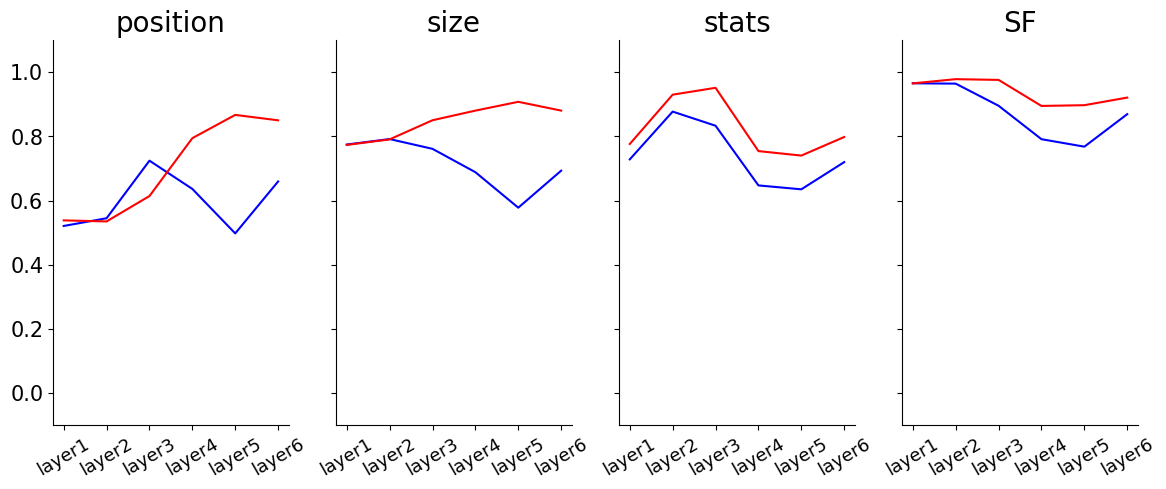

In [10]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = (14,5)

N_COL = 4
fig, axes = plt.subplots(nrows=1, ncols=N_COL,  sharey=True)

x= ['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6']
for i, exp in enumerate(['position', 'size', 'stats','SF']):
    axes[i].plot(x, d_result['exp_'+exp.lower()], 'blue')
    axes[i].plot(x, d_resnet['exp_'+exp.lower()], 'red')

    
#     axes[i].fill_between(x, y-error, y+error, alpha=0.1, facecolor='black')
    axes[i].set_title(exp, fontsize=20)
    axes[i].set_ylim(-0.1,1.1)
    axes[i].spines.right.set_visible(False)
    axes[i].spines.top.set_visible(False)
    axes[i].tick_params(axis='y', labelsize=15)
    axes[i].tick_params(axis='x', labelsize=13, rotation=30)
    
plt.show()

In [7]:
import json
filename = 'our-euc-spearman-all'
with open(f'./results/imagenet-16/{filename}.json', 'w') as f:
    json.dump(d_result, f)

# previous version

In [166]:

DIR_DATASET = '/home/young/hdd1'

def load_imgpath(imagefilelist, category, n_sample=10):
    img_names = []
    with open(imagefilelist, 'r') as f:
        lines = f.readlines()
        for line in lines:
            data = line.strip().split(' ')
            if int(data[1]) == d_name2idx[category]:
                img_names.append(data[0])
                
    random.seed(10)
    img_names = random.sample(img_names, n_sample)
    img_names = [im.replace('/data/datasets', DIR_DATASET) for im in img_names]
    return img_names

import matplotlib.pyplot as plt
from torchvision.utils import save_image

def load_images(img_names, category, condition, expname, visualize=False, save_dir=None):
    
    if condition == 'orig':
        val_trans = transforms.Compose([
                        transforms.Resize(256),                   
                        transforms.CenterCrop(224),
                        transforms.ToTensor()
                      ])
    
    else:
        if expname == 'exp_size':
            val_trans = transforms.Compose([
                            transforms.Resize(256),
                            transforms.CenterCrop(224),
                            transforms.RandomAffine(degrees=0, translate=None, scale=(1.5,1.5)),
                            transforms.ToTensor()
                          ])

        if expname == 'exp_position':
            val_trans = transforms.Compose([
                            transforms.Resize(256),                   
                            transforms.CenterCrop(224),
                            transforms.RandomAffine(degrees=0, translate=(0.5, 0.5), scale=None),
                            transforms.ToTensor()
                          ])

        


    imgs=[]
    for img in img_names:
        img = Image.open(img).convert('RGB') 
        if img is None:
            print(im_name)
        img = val_trans(img)
        imgs.append(img)
        
        
    if visualize:
        for img in imgs:
            plt.imshow(img.cpu().numpy().transpose((1, 2, 0)))
            plt.show()
#         for i, (oimg, timg) in enumerate(zip(orig_imgs, trans_imgs)):
#             fig, (ax1, ax2) = plt.subplots(1, 2)    
#             ax1.imshow(oimg.cpu().numpy().transpose((1, 2, 0)))
#             ax2.imshow(timg.cpu().numpy().transpose((1, 2, 0)))
#             plt.show()

    if save_dir is not None:
        for i, img in enumerate(imgs):
            path_img = os.path.join(save_dir, expname, f'{category}_{condition}', f'{category}{i}.jpeg')
            if not os.path.exists(os.path.dirname(path_img)):
                os.makedirs(os.path.dirname(path_img))
            save_image(img, path_img)
            
#         for i, (oimg, timg) in enumerate(zip(orig_imgs, trans_imgs)):
#             path_orig = os.path.join(save_dir, expname, f'{category}_original', f'{category}_{i}.jpeg')
#             path_transform =os.path.join(save_dir, expname, f'{category}_transform', f'{category}_{i}.jpeg')

#             if not os.path.exists(os.path.dirname(path_orig)):
#                 os.makedirs(os.path.dirname(path_orig))
#             if not os.path.exists(os.path.dirname(path_transform)):
#                 os.makedirs(os.path.dirname(path_transform))

#             save_image(oimg, path_orig)
#             save_image(timg, path_transform)
        print('images saved to disk')

            
    return imgs

In [167]:
imagefilelist = './data/imagenet-16/imagenet-16-val_list.txt'

expname = 'exp_size'
# expname = 'exp_stats'
# expname = 'exp_position'





===start elephant
images saved to disk
start extraction on elephant,  0.9

===start chair
images saved to disk
start extraction on chair,  0.9

===start bicycle
images saved to disk
start extraction on bicycle,  0.9

===start car
images saved to disk
start extraction on car,  1.0

===start bird
images saved to disk
start extraction on bird,  1.0

===start truck
images saved to disk
start extraction on truck,  0.9

===start dog
images saved to disk
start extraction on dog,  1.0

===start boat
images saved to disk
start extraction on boat,  1.0

===start keyboard
images saved to disk
start extraction on keyboard,  0.9

===start bottle
images saved to disk
start extraction on bottle,  0.8

===start cat
images saved to disk
start extraction on cat,  1.0

===start knife
images saved to disk
start extraction on knife,  0.6

===start airplane
images saved to disk
start extraction on airplane,  0.9

===start clock
images saved to disk
start extraction on clock,  1.0

===start bear
images save

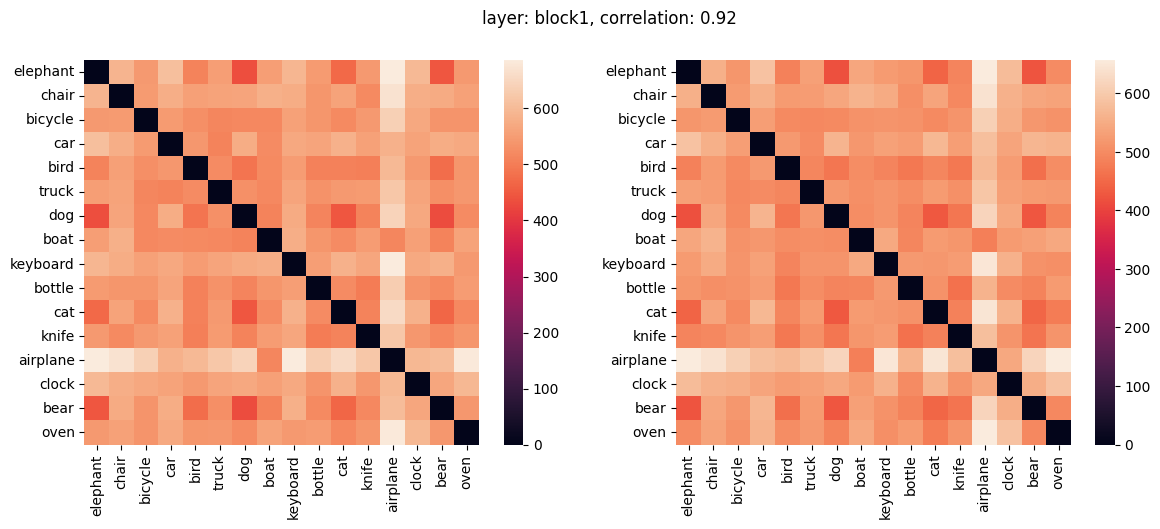

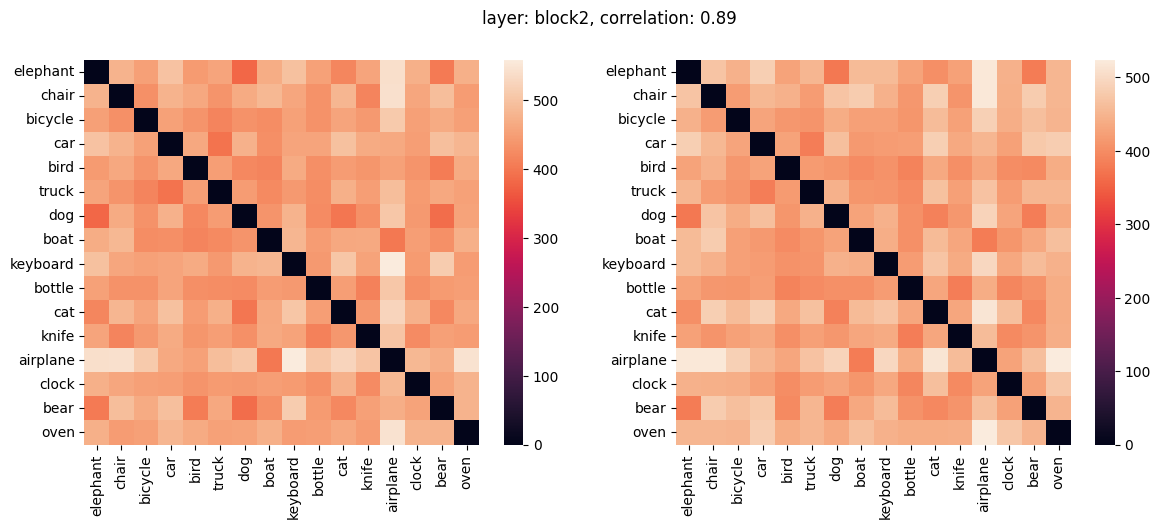

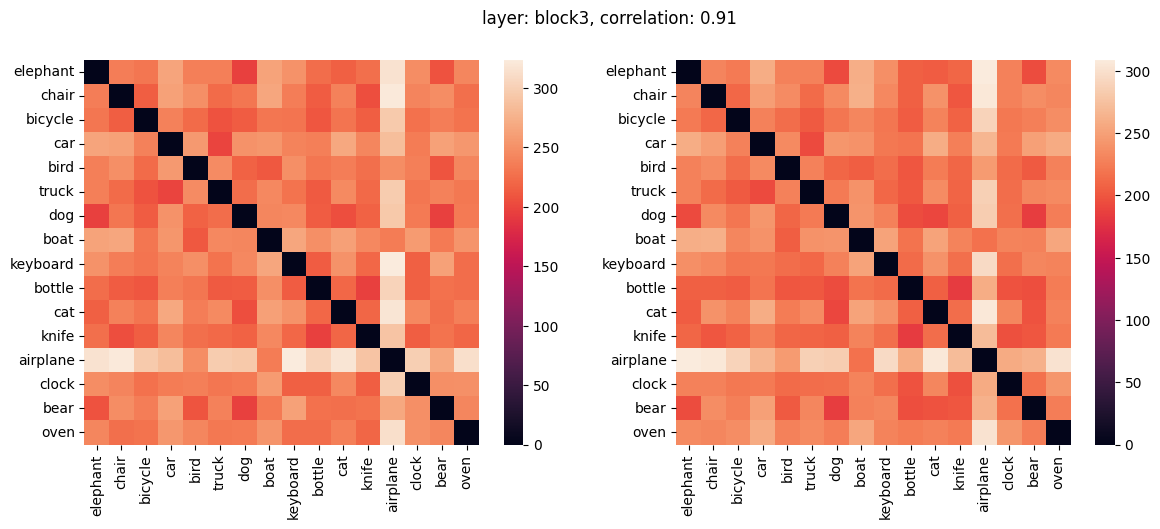

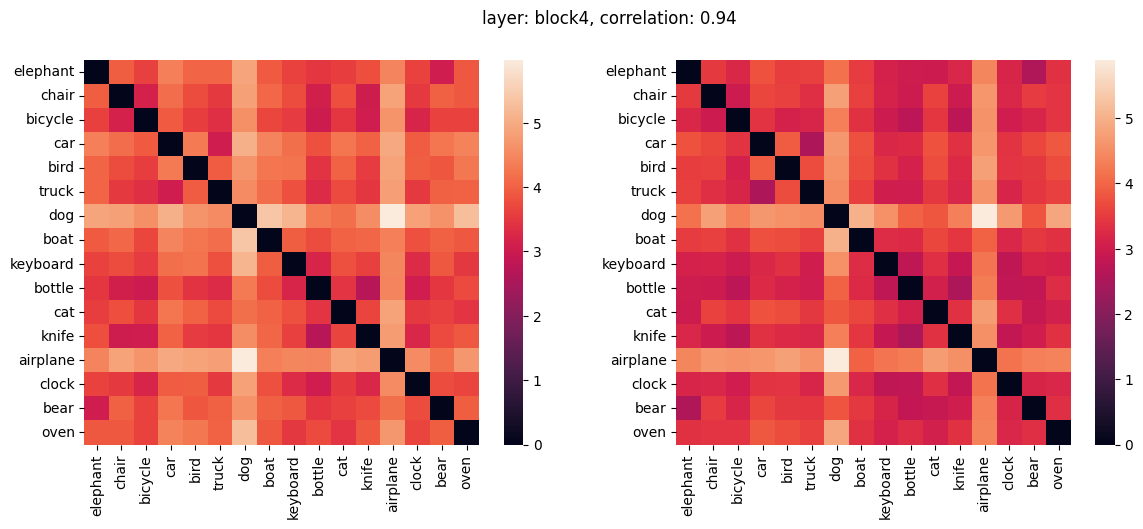

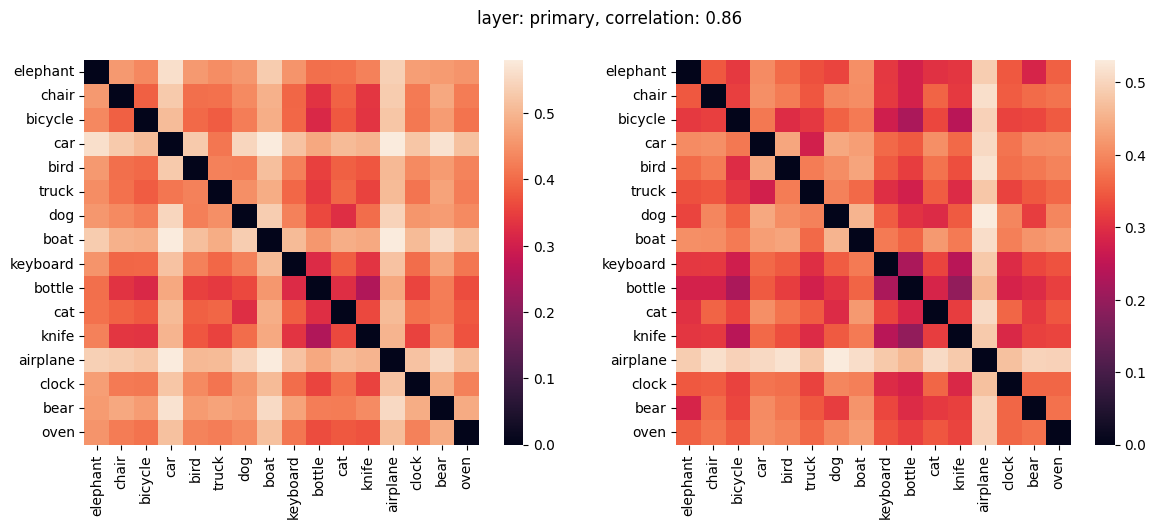

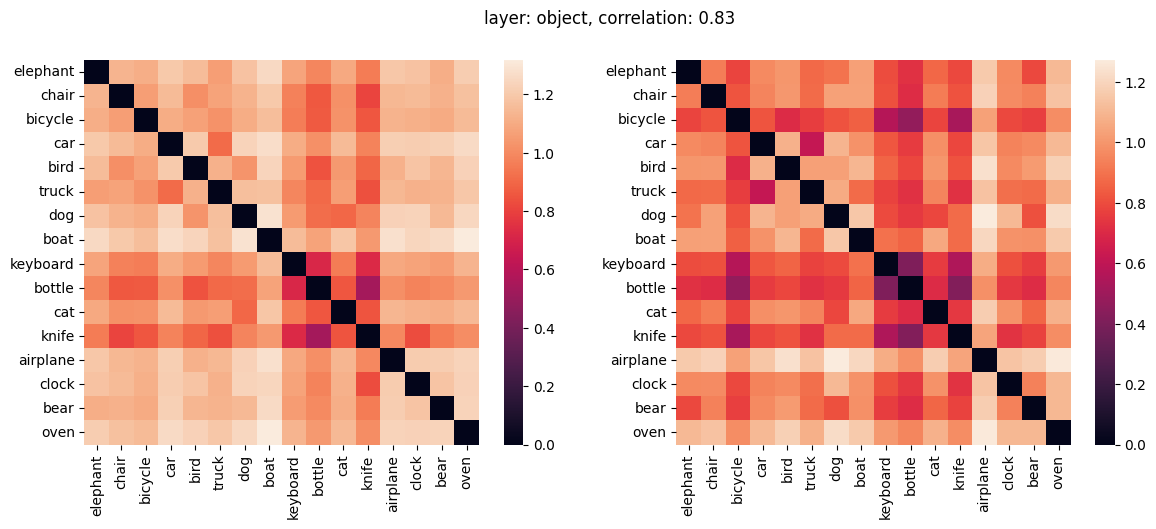

In [168]:
d_result= {}

categories = list(d_name2idx.keys())
feature_name = ['block1', 'block2', 'block3', 'block4', 'primary', 'object']
DISTANCE_METRIC = 'euclidean' #'euclidean'

d_rdm = defaultdict(dict)

for ci, condition in enumerate(['orig', 'trans']):
    d_features = defaultdict(dict)
    
    for category in categories:
        
        print('\n===start', category)
        
        # load images
        img_names = load_imgpath(imagefilelist, category)
        imgs = load_images(img_names, category, condition, expname, visualize=False, save_dir='./data/imagenet-16/')

        # register hooks for feature extraction
        features = []

        def get_outputs():
            def hook(model, input, output):
                features.append(output.detach())
            return hook

        def get_routingoutputs():
            def hook(model, input, output):
                features.append(output[0].detach())
            return hook

        hook1 = model.encoder.enc.conv2.register_forward_hook(get_outputs())
        hook2 = model.encoder.enc.conv3.register_forward_hook(get_outputs())
        hook3 = model.encoder.enc.conv4.register_forward_hook(get_outputs())
        hook4 = model.encoder.enc.conv5.register_forward_hook(get_outputs())
        hook5 = model.encoder.capsulate.register_forward_hook(get_outputs())
        hook6 = model.capsule_routing.register_forward_hook(get_routingoutputs())

        # predict
        x = torch.stack(imgs).to(args.device)
        objcaps_len_step, x_recon_step = predict(model, args, x)

        hook1.remove()
        hook2.remove()
        hook3.remove()
        hook4.remove()
        hook5.remove()
        hook6.remove()

        # accuracy
        objcaps_len_step_narrow = objcaps_len_step.narrow(dim=-1,start=0, length=16) # in case a background cap was added    
        y_pred = objcaps_len_step_narrow[:,-1]
        topk_indices = y_pred.topk(3, sorted=True)[1]

        if category in d_name2idx.keys():
            correct_idx = d_name2idx[category]
            correct_trial = [True if correct_idx in toklist else False for toklist in topk_indices]
        # topk_indices = list(topk_indices.flatten().cpu().numpy())
        # predictions = [d_idx2name[int(idx)] for idx in topk_indices]
        # print(predictions)
            print(f'start extraction on {category}, ', np.mean(correct_trial))
        else:
            print(f'start extraction on {category}, ', 'NA')
    #             if np.array(correct_trial).any() ==False:
    #                 print(category)
    #                 raise Error


        for i, f in enumerate(features):
        #     print(f.shape)
    #                 avg_f = f[correct_trial].mean(dim=0).cpu().numpy().flatten()
            avg_f = f.mean(dim=0).cpu().numpy().flatten()
        #     print(avg_f.shape)
            d_features[feature_name[i]][category] = avg_f.flatten()
           
        
    print('\n\n===start rdm analysis')

    for feature in feature_name:
        print('--on ', feature)
    #     feature = 'object'
        mat = []
        for cat in categories:
            mat.append(d_features[feature][cat])
        mat = np.array(mat)
        pdmat = pairwise_distances(mat, metric=DISTANCE_METRIC)

        d_rdm[feature][condition] = pdmat 
    
# save data
correlation= []
for feature in feature_name:
    mats = []
    for condition in d_rdm[feature].keys():
        mats.append(d_rdm[feature][condition])


    c = spearmanr(mats[0].flatten(), mats[1].flatten())[0] #spearmanr
    correlation.append(c) 

    plt.rcParams["figure.figsize"] = (14,5)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(f'layer: {feature}, correlation: {round(c,2)}')
    sns.heatmap(mats[0], annot=False, fmt=".2f", ax=ax1, xticklabels=categories, yticklabels=categories)
    sns.heatmap(mats[1], annot=False, fmt=".2f", ax=ax2, xticklabels=categories, yticklabels=categories)
    plt.show()

d_result[expname] =correlation

In [156]:
d_features['block1']

{'elephant': array([0.41852757, 0.3651645 , 0.84294766, ..., 0.90176296, 1.0562849 ,
        1.2054584 ], dtype=float32),
 'chair': array([0.9515937 , 0.61921644, 1.226801  , ..., 1.3891599 , 1.4015521 ,
        1.7760556 ], dtype=float32),
 'bicycle': array([0.12214847, 0.69284016, 0.89132446, ..., 0.8530278 , 1.0925022 ,
        0.98902553], dtype=float32),
 'car': array([0.13022481, 0.30447984, 0.61242753, ..., 0.7916162 , 0.9662005 ,
        1.0985498 ], dtype=float32),
 'bird': array([0.10968671, 0.09057899, 0.68365276, ..., 0.84856874, 1.5441412 ,
        1.9833416 ], dtype=float32),
 'truck': array([0.3473139 , 0.46900484, 1.2542547 , ..., 0.5103321 , 0.9007966 ,
        0.70935744], dtype=float32),
 'dog': array([0.28500107, 0.15448873, 1.0277321 , ..., 1.149064  , 0.84973717,
        0.31788903], dtype=float32),
 'boat': array([0.19478521, 0.        , 0.47320494, ..., 0.35932496, 0.76767415,
        0.7739789 ], dtype=float32),
 'keyboard': array([0.24384801, 0.11898731, 0.861

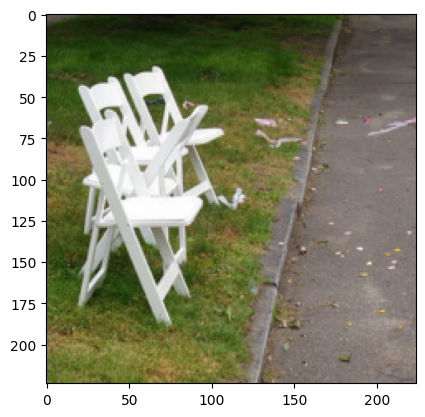

In [116]:
import matplotlib.pyplot as plt
plt.imshow(img.cpu().numpy().transpose((1, 2, 0)))